![Callysto.ca Banner](https://github.com/callysto/curriculum-notebooks/blob/master/callysto-notebook-banner-top.jpg?raw=true)

<a href="https://hub.callysto.ca/jupyter/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fcallysto%2Fcallysto-sample-notebooks&branch=master&subPath=notebooks/General_Interest/NHL-Requests.ipynb&depth=1" target="_parent"><img src="https://raw.githubusercontent.com/callysto/curriculum-notebooks/master/open-in-callysto-button.svg?sanitize=true" width="123" height="24" alt="Open in Callysto"/></a>

In [1]:
import pandas as pd
import requests

# Exploring an API with Python

This notebook uses the python requests module to experiment with the (undocumented) NHL statistics API. This API is by the NHL to drive lots of the functionality on nhl.com such as the live game tracker. Here, we use it to document the process of exploring a new API in the notebook environment. 

All of the code that follows is rough and ready. It is fit for purpose, but shouldn't be considerd production ready.


## NHL API

The NHL publish statistics on games, players, standings and lots of other things in an unpublished api at https://statsapi.web.nhl.com. Some enterprising people have started [documenting the various end points](https://github.com/dword4/nhlapi) but it is still very much a work in progress. Some specific examples of endpoints are e.g

 * GET https://statsapi.web.nhl.com/api/v1/game/ID/feed/live Returns all data about a specified game id including play data with on-ice coordinates and post-game details like first, second and third stars and any details about shootouts. The data returned is simply too large at often over 30k lines and is best explored with a JSON viewer.

 * GET https://statsapi.web.nhl.com/api/v1/game/ID/boxscore Returns far less detail than feed/live and is much more suitable for post-game details including goals, shots, PIMs, blocked, takeaways, giveaways and hits.

 * GET http://statsapi.web.nhl.com/api/v1/game/ID/content Complex endpoint returning multiple types of media relating to the game including videos of shots, goals and saves.

# Teams

Start off by collecting a list of current teams. This is pretty static information so we could collect it other ways, but in principal as soon as the NHL decide to give a team to seattle we're ready to roll!

In [2]:
response = requests.get("https://statsapi.web.nhl.com/api/v1/teams")
if response.status_code != 200:
    print("FAILED")
    response.raise_for_status()

We examined the status_code for the response to make sure that it was successful (200 is HTTP for "OK"). This is a good idea, but we'll skip it in later cells for brevity.

Since this API is undocumented, we will take a quick look to see what information is being returned from that endpoint. We can do this by asking for the request result as JSON (Javascript Object Notation) 

In [3]:
response.json().keys()

dict_keys(['copyright', 'teams'])

In [4]:
teams = response.json()['teams']
teams[0]

{'abbreviation': 'NJD',
 'active': True,
 'conference': {'id': 6, 'link': '/api/v1/conferences/6', 'name': 'Eastern'},
 'division': {'id': 18,
  'link': '/api/v1/divisions/18',
  'name': 'Metropolitan'},
 'firstYearOfPlay': '1982',
 'franchise': {'franchiseId': 23,
  'link': '/api/v1/franchises/23',
  'teamName': 'Devils'},
 'franchiseId': 23,
 'id': 1,
 'link': '/api/v1/teams/1',
 'locationName': 'New Jersey',
 'name': 'New Jersey Devils',
 'officialSiteUrl': 'http://www.truesince82.com',
 'shortName': 'New Jersey',
 'teamName': 'Devils',
 'venue': {'city': 'Newark',
  'link': '/api/v1/venues/null',
  'name': 'Prudential Center',
  'timeZone': {'id': 'America/New_York', 'offset': -5, 'tz': 'EST'}}}

We have the ordinary stuff like 'name' and 'location' along with some more detail. One thing to notice is the 'id' value, which is used by some of the other endpoints to uniquely identify a team. We can find a specific id by looping through the teams until we find the one we want.

In [5]:
teamName = 'Calgary Flames'

teams = response.json()['teams']
for team in teams:
    if team['name'] == 'Calgary Flames':
        teamID = team['id']
        
print("teamID {}: {}".format(teamID, teamName))

teamID 20: Calgary Flames


Pandas is a very useful module which helps organize and manipulate data. The main abstraction used by pandas is the DataFrame. In it's simplest incarnation a DataFrame is simply a table of Data which can be filtered, combined, updated. Let's construct a dataframe with to look at the when the teams joined the league.

In [6]:
teamDF = pd.DataFrame()

for team in teams:
    df = pd.DataFrame().from_records(
        {
        'firstYearOfPlay': int(team['firstYearOfPlay']),
        'name': team['name']
        }, index=[team['id']])

    if teamDF is None:
        teamDF = df
    else:
        teamDF = teamDF.append(df)

teamDF.sort_values('firstYearOfPlay')

,firstYearOfPlay,name
8,1909,Montréal Canadiens
10,1917,Toronto Maple Leafs
6,1924,Boston Bruins
16,1926,Chicago Blackhawks
17,1926,Detroit Red Wings
3,1926,New York Rangers
4,1967,Philadelphia Flyers
26,1967,Los Angeles Kings
25,1967,Dallas Stars
19,1967,St. Louis Blues


It looks like the data only covers the current franchise holders (or the Canadiens played a lot of really one sided games back in the early 1900s).

## Schedule

The schedule endpoint includes data on past, current and future games. First we will grab a list of games from 2017-2018 season up till yesterday.

In [7]:
day = (pd.datetime.today() - pd.Timedelta("1 days"))

In [8]:
day.strftime('%Y-%m-%d')

'2018-01-29'

In [9]:
params = {
    'startDate' : '2017-10-04',
    'endDate'   : (pd.datetime.today() - pd.Timedelta("1 days")).strftime('%Y-%m-%d'),
    'teamID'    : teamID
}
response = requests.get("https://statsapi.web.nhl.com/api/v1/schedule", params=params)

if response.status_code != 200:
    print("FAILED")
else:
    print(response.url)

https://statsapi.web.nhl.com/api/v1/schedule?startDate=2017-10-04&endDate=2018-01-29&teamID=20


The structure returned this time is a bit more complicated.

In [10]:
response.json().keys()

dict_keys(['copyright', 'totalItems', 'totalEvents', 'totalGames', 'totalMatches', 'wait', 'dates'])

The 'dates' key contains most of the information. Each element inside it is a date with one or more games taking place, we will look at the first date (element "0") as an example.

In [11]:
response.json()['dates'][0].keys()

dict_keys(['date', 'totalItems', 'totalEvents', 'totalGames', 'totalMatches', 'games', 'events', 'matches'])

This time most of the good information is inside te 'games' key. Inside that, we have entries for the home and away teams. Remember from above, we set teamID to identify one team. Let's loop over all of the games in the range and find the games

In [12]:
gameDays = response.json()['dates']

homeGames = []
awayGames = []
for day in gameDays:
    for game in day['games']:
        
        if game['teams']['home']['team']['id'] == teamID:
            homeGames.append(game['gamePk'])
        elif game['teams']['away']['team']['id'] == teamID:
            awayGames.append(game['gamePk'])

print("home/away: {0}/{1}".format(len(homeGames), len(awayGames)))

home/away: 26/23


## Games

Most of the detail in the API is in the game endpoints. For example, let's take the last home game from above and pull out the boxscore

In [13]:
response = requests.get(
    'https://statsapi.web.nhl.com/api/v1/game/{}/boxscore'.format(homeGames[-1])
)

if response.status_code != 200:
    print("FAILED")
else:
    print(response.url)

https://statsapi.web.nhl.com/api/v1/game/2017020745/boxscore


In [14]:
response.json().keys()

dict_keys(['copyright', 'teams', 'officials'])

We have everything from the officials to the birthplacesof each skater! Let's look at the shot totals as a function of time

In [15]:
response.json()['teams']['home']['teamStats']

{'teamSkaterStats': {'blocked': 10,
  'faceOffWinPercentage': '50.7',
  'giveaways': 16,
  'goals': 1,
  'hits': 21,
  'pim': 22,
  'powerPlayGoals': 0.0,
  'powerPlayOpportunities': 5.0,
  'powerPlayPercentage': '0.0',
  'shots': 31,
  'takeaways': 6}}

OK, let's build a dataframe with the data above for each game

In [16]:
pd.DataFrame.from_records(response.json()['teams']['home']['teamStats']['teamSkaterStats'],
                          index=[homeGames[-1]]
                         )

,blocked,faceOffWinPercentage,giveaways,goals,hits,pim,powerPlayGoals,powerPlayOpportunities,powerPlayPercentage,shots,takeaways
2017020745,10,50.7,16,1,21,22,0.0,5.0,0.0,31,6


**N.B. This cell will make lots of requests**

Most API providers will rate limit requests at some level, but since the nhl stats API is largely undocumented, I don't know what they will be! The cell below will take all home games (to date) and ask for their box scores as quickly as it can. If you run into errors take a look at the contents of response (raise_for_status())

In [17]:
homeGameDF = pd.DataFrame()

for game in homeGames:
    response = requests.get(
        'https://statsapi.web.nhl.com/api/v1/game/{}/boxscore'.format(game)
    )

    if response.status_code != 200:
        response.raise_for_status()
    else:
        response.json()['teams']['home']['teamStats']['teamSkaterStats']
        df = pd.DataFrame().from_records(
            response.json()['teams']['home']['teamStats']['teamSkaterStats'],
            index=[game]
        )
        
    if homeGameDF is None:
        homeGameDF = df
    else:
        homeGameDF = homeGameDF.append(df)

homeGameDF

,blocked,faceOffWinPercentage,giveaways,goals,hits,pim,powerPlayGoals,powerPlayOpportunities,powerPlayPercentage,shots,takeaways
2017020027,10,47.1,7,6,15,6,2.0,6.0,33.3,45,6
2017020061,6,50.8,9,0,12,19,0.0,3.0,0.0,25,10
2017020102,22,45.8,13,1,14,12,0.0,1.0,0.0,26,5
2017020120,10,50.0,11,2,15,6,1.0,6.0,16.7,37,6
2017020154,13,56.7,7,1,16,8,0.0,2.0,0.0,30,12
2017020169,8,45.0,4,2,20,4,0.0,2.0,0.0,38,13
2017020195,7,55.0,8,2,14,2,1.0,4.0,25.0,34,12
2017020216,14,52.1,12,4,11,4,0.0,3.0,0.0,34,11
2017020230,13,43.4,13,3,10,6,2.0,4.0,50.0,32,14
2017020239,16,43.8,11,6,13,11,0.0,2.0,0.0,34,18


In [18]:
homeGameDF.sort_index(inplace=True)

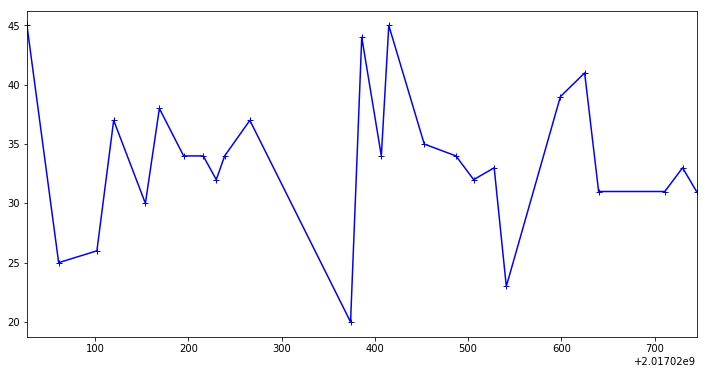

In [20]:
homeGameDF['shots'].plot(figsize=(12, 6), style=['b+-'])

With more data, we could look at the correlation between opposing teams and penalty minutes.

[![Callysto.ca License](https://github.com/callysto/curriculum-notebooks/blob/master/callysto-notebook-banner-bottom.jpg?raw=true)](https://github.com/callysto/curriculum-notebooks/blob/master/LICENSE.md)